In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math

### Bolinger Band 그리기 위한 sigma 계산 helper function

In [2]:
def variance_calculator(series, series_average, win_len):
    sma = win_len
    temp1 = series.subtract(series_average) # a-b
    temp2 = temp1.apply(lambda x: x**2)    # (a-b)^2
    temp3 = temp2.rolling(sma - 1).mean() # sum((a-b)^2) / (sma-1)
    sigma = temp3.apply(lambda x: math.sqrt(x))  # standard deviation
    return sigma

### Quandl 에서 2015.1.1 부터의 매일의 S&P500 선물 지수 및 거래량 정보, 상승 주식 종목수/거래량, 하락 주식 종목수/거래량 download 

In [3]:
def fetch_data(string1, string2, string3, filename):
    w = quandl.get(string1, authtoken = string2, start_date = string3)
    w.to_csv(filename)
    w = pd.read_csv(filename)
    return w

In [4]:
# S&P500 future data fetch from "CHRIS/CME_SP1" database
Data1 = fetch_data("CHRIS/CME_SP1", "U_Gp39gZutpHmaFgC65Y","2014-12-12", "local_future.csv")
Data = fetch_data("CBOE/SPX_PC", "U_Gp39gZutpHmaFgC65Y", "2014-12-12", "local_data.csv")

In [5]:
Data1.head(2)           # S&P500 daily price/volume

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,2014-12-12,2020.5,2031.0,1997.5,1997.5,33.7,1997.2,28520.0,126742.0
1,2014-12-15,2013.5,2018.5,1982.0,1991.0,7.2,1990.0,18085.0,101988.0


In [6]:
Data.head(2)            # S&P500 PCR

,Date,S&P PUT-CALL RATIO,S&P PUT VOLUME,S&P CALL VOLUME,PREV. DAY OPEN INTEREST
0,2014-12-12,2.49,1072264.0,430079.0,1502343.0
1,2014-12-15,2.46,913199.0,371125.0,1284324.0


In [7]:
Data['future'] = Data1['Last']
Data['PCR'] = Data['S&P PUT-CALL RATIO']

In [8]:
Data.head(2)            

,Date,S&P PUT-CALL RATIO,S&P PUT VOLUME,S&P CALL VOLUME,PREV. DAY OPEN INTEREST,future,PCR
0,2014-12-12,2.49,1072264.0,430079.0,1502343.0,1997.5,2.49
1,2014-12-15,2.46,913199.0,371125.0,1284324.0,1991.0,2.46


### Initialize variables which will be used later

In [9]:
sma = 20 # moving average window length
k = 1  # Bollinger band 작성시 sigma 의 몇배를 적용할 것인가 하는 상수
l = 1    # Bollinger band 에서 sigma 의 몇배에서 stop loss 할 것인지 정하는 상수
pro = 0  # profit
transaction_start_price = 0
flag = 1 # first transaction 을 하기 위한 flag. 거래는 LBB/UBB crossing over 에서만 시작함
buy_flag = False
sell_flag = False
abs_SL = 50 # absolute stop loss 값
mtm = list()
order_details = list()
order = list()  # orders list : BUY/SELL/DO_nothing
profit = list()
buy_sell = list()
stoploss = list()
trade_cause = list()

In [10]:
Data['mAvg'] = Data['PCR'].rolling(sma).mean()   # moving average of PCR

In [11]:
Data['PCR_prev'] = Data['PCR'].shift(1)

In [12]:
sigma = variance_calculator(Data['PCR'], Data['mAvg'], sma)  # standard deviation

In [13]:
k_sigma = k * sigma
l_sigma = l * sigma

In [14]:
Data['UBB'] = Data['mAvg'].add(k_sigma)       # Upper Bolinger Band
Data['USL'] = Data['UBB'].add(l_sigma)        # Upper Stop Loss Band
Data['LBB'] = Data['mAvg'].subtract(k_sigma)  # Lower Bolinger Band
Data['LSL'] = Data['LBB'].subtract(l_sigma)   # Lower Stop Loss Band
Data['order'] = pd.Series()   # list of orders - BUY/SELL/DO_nothing

In [15]:
s = Data['PCR'].size           # total number of data points

In [16]:
for i in range(s):
	
	pro = 0 # profit at each trade
	#variables to be used for comarison
	future_cost = Data['future'][i]#...........cost of big S&P 500 futures bought
	PCR      =   Data['PCR'][i]#...............current putcall ratio value
	PCR_prev  =   Data['PCR_prev'][i]#.........previous day's put call ratio (for crossover check)
	LBB      =   Data['LBB'][i] #..............lower bollinger band
	UBB      =   Data['UBB'][i]#...............upper bollinger band
	mAvg     =   Data['mAvg'][i]#..............moving average
	USL      =   Data['USL'][i]#...............upper stoploss band
	LSL      =   Data['LSL'][i] #..............lower stoploss band
    
    #comparisons stored as boolean variables to place order accordingly
	UBB_cross        =   (PCR > UBB) and (PCR_prev < UBB)# .......Check if PCR crosses upper bollinger band
	LBB_cross        =   (PCR < LBB) and (PCR_prev > LBB)# .......Check if PCR crosses lower bollinger band
	mAvg_cross_up    =   (PCR > mAvg) and (PCR_prev < mAvg)#......Check if PCR crosses moving average low to high
	mAvg_cross_down  =   (PCR < mAvg) and (PCR_prev > mAvg)#......Check if PCR crosses moving average high to low
	USL_cross        =   (PCR > USL)  and  (PCR_prev < USL)#......Check if PCR crosses upper stoploss band
	LSL_cross        =   (PCR < LSL)  and  (PCR_prev > LSL)#......Check if PCR crosses lower stoploss band

	if(UBB_cross and (not buy_flag) and flag ==1): #...........places "BUY" order if PCR crosses upper bollinger band to open a trade
		flag = 0
		buy_flag = True      
		sell_flag = False
		transaction_start_price = future_cost #............price at which S&P 500 future bought when order is placed
		order_details = [1,"Buy" , "UBB crossed" , "0" , "position taken"]
	
	elif (LBB_cross and (not sell_flag) and flag ==1): #.......places "SELL" order if PCR crosses lower bollinger band to open a trade
		flag = 0
		sell_flag = True  
		buy_flag = False
		transaction_start_price = future_cost
		order_details = [-1,"Sell" , "LBB crossed" , "0" , "position taken"]
	
	elif (mAvg_cross_up and flag==0 and (not buy_flag)) : #........places "BUY" order if PCR crosses mAvg from low to high to close a trade  
		flag = 1
		buy_flag = False 
		sell_flag = False
		pro = future_cost -transaction_start_price
		order_details = [1,"Buy" , "mAvg crossed" , "0" , "position closed"]
		
	elif( LSL_cross and flag == 0 and (not buy_flag)):#......places "BUY" order if PCR crosses lower stoploss band to close a trade
		flag = 1
		buy_flag = False
		sell_flag = False
		pro = future_cost - transaction_start_price
		order_details = [1,"Buy" , "LSB crossed" , "stoploss executed" , "position closed"]
	elif( (future_cost - transaction_start_price) > abs_SL and flag == 0 and (not buy_flag)):#......places "BUY " order if PCR crosses lower stoploss absolute value
		flag = 1
		buy_flag = False
		sell_flag = False
		pro = future_cost - transaction_start_price
		order_details = [1,"Buy" , "LSB crossed" , "stoploss executed abs" , "position closed"]		
				
	elif (mAvg_cross_down and flag==0 and (not sell_flag)):#.....places "SELL" order if PCR crosses mAvg from high to low to close a trade
		flag = 1
		sell_flag = False
		buy_flag = False
		pro = -(Data['future'][i] - transaction_start_price)
		order_details = [-1,"Sell" , "mAvg crossed (h to l)" , "0" , "position closed"]
					
	elif(USL_cross and flag==0 and (not sell_flag)):# ..places "SELL" order if PCR crosses upper stoploss band to close a trade
		flag = 1
		sell_flag = False
		buy_flag = False
		pro = -(Data['future'][i] - transaction_start_price)
		order_details = [-1,"Sell" , "USB crossed" , "stoploss executed" , "position closed"]
	
	elif((-future_cost + transaction_start_price) > abs_SL and flag==0 and (not sell_flag)):# ..places "SELL" order if PCR crosses upper stoploss absolute value
		flag = 1
		sell_flag = False
		buy_flag = False
		pro = -(Data['future'][i] - transaction_start_price)
		order_details = [-1,"Sell" , "USB crossed" , "stoploss executed_abs" , "position closed"]


	else:
		if(buy_flag==0 and sell_flag==0): tempo = "0"
		else:
			if(buy_flag==1 and sell_flag==0): tempo = (Data['future'][i] -transaction_start_price) * 500
			if(buy_flag==0 and sell_flag==1): tempo= (-Data['future'][i] +transaction_start_price) * 500
		order_details = [0,"No trade" , "no trade" , "0" , tempo]
	

	profit.append(pro)
	order.append(order_details[0])
	buy_sell.append(order_details[1])
	trade_cause.append(order_details[2])
	stoploss.append(order_details[3])
	mtm.append(order_details[4])

In [17]:
Data['placed_order'] = pd.Series(order)
Data['cost'] = -(Data['placed_order'].multiply(Data['future'])) * 500
Data['out']  = Data['cost'].cumsum()
Data['buy_sell'] = pd.Series(buy_sell)
Data['profit'] = -pd.Series(profit) * 500
Data['stoploss'] = pd.Series(stoploss)
Data['trade_cause'] = pd.Series(trade_cause)
Data['mtm'] = pd.Series(mtm)
print(Data['out'])

0           -0.0
1           -0.0
2           -0.0
3           -0.0
4           -0.0
5           -0.0
6           -0.0
7           -0.0
8           -0.0
9           -0.0
10          -0.0
11          -0.0
12          -0.0
13          -0.0
14          -0.0
15          -0.0
16          -0.0
17          -0.0
18          -0.0
19          -0.0
20          -0.0
21          -0.0
22          -0.0
23          -0.0
24          -0.0
25          -0.0
26          -0.0
27          -0.0
28          -0.0
29          -0.0
         ...    
892    3687850.0
893    5051350.0
894    5051350.0
895    5051350.0
896    5051350.0
897    5051350.0
898    5051350.0
899    5051350.0
900    6450750.0
901    6450750.0
902    5052250.0
903    6457750.0
904    6457750.0
905    6457750.0
906    5057500.0
907    5057500.0
908    5057500.0
909    6478250.0
910    5057000.0
911    5057000.0
912    5057000.0
913    5057000.0
914    3651750.0
915    3651750.0
916    3651750.0
917    5076800.0
918    5076800.0
919    5076800

In [18]:
output = pd.DataFrame() #....final output to be stored in excel file
output['date'] = Data['Date']
output['Close'] = Data['future']
output['PCR'] = Data['PCR']
output['placed_order'] = Data['placed_order']
output['buy_sell'] = Data['buy_sell']
output['trade_cause'] =  Data['trade_cause']
output['PnL'] = Data['profit']
output['mtm'] = Data['mtm']
output['stoploss'] = Data['stoploss']
output['Cash Account'] = Data['out']
output.to_excel('PCR_SL_output.xlsx', sheet_name='Sheet1')

In [19]:
Data['out']

0           -0.0
1           -0.0
2           -0.0
3           -0.0
4           -0.0
5           -0.0
6           -0.0
7           -0.0
8           -0.0
9           -0.0
10          -0.0
11          -0.0
12          -0.0
13          -0.0
14          -0.0
15          -0.0
16          -0.0
17          -0.0
18          -0.0
19          -0.0
20          -0.0
21          -0.0
22          -0.0
23          -0.0
24          -0.0
25          -0.0
26          -0.0
27          -0.0
28          -0.0
29          -0.0
         ...    
892    3687850.0
893    5051350.0
894    5051350.0
895    5051350.0
896    5051350.0
897    5051350.0
898    5051350.0
899    5051350.0
900    6450750.0
901    6450750.0
902    5052250.0
903    6457750.0
904    6457750.0
905    6457750.0
906    5057500.0
907    5057500.0
908    5057500.0
909    6478250.0
910    5057000.0
911    5057000.0
912    5057000.0
913    5057000.0
914    3651750.0
915    3651750.0
916    3651750.0
917    5076800.0
918    5076800.0
919    5076800

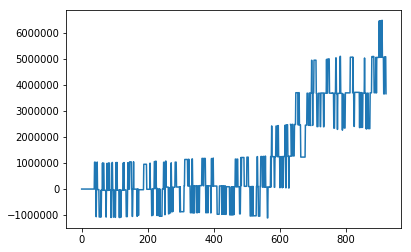

In [20]:
plt.plot(Data['out'])